# Text Classification

### Simple Neural Network

In [2]:
import pandas as pd
import re

file_path = 'games1.csv' 
df = pd.read_csv(file_path)

# Cleaning the moves column (can't let it cheat)
def clean_moves_column(moves):

    patterns_to_remove = [
        r'White wins', r'Black wins', r'1-0', r'1/2-1/2', r'0-1'
    ]

    combined_pattern = '|'.join(patterns_to_remove)

    cleaned_moves = re.sub(combined_pattern, '', moves, flags=re.IGNORECASE)
    return cleaned_moves

df['moves'] = df['moves'].apply(clean_moves_column)

output_path = 'cleaned_lichess_user_games.csv'
df.to_csv(output_path, index=False)

print(f"Cleaned data saved to {output_path}")


Cleaned data saved to cleaned_lichess_user_games.csv


In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


file_path = 'cleaned_lichess_user_games.csv' 
df = pd.read_csv(file_path)

# Preprocess target variable
df['result_encoded'] = df['result'].map({'1-0': 1, '0-1': 0, '1/2-1/2': 2})
df = df.dropna(subset=['moves', 'result_encoded'])  # Drop rows withh problems (missing data)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=10,
    stop_words="english"
)
vector_data = vectorizer.fit_transform(df['moves'])
print(f"Vectorized moves data shape: {vector_data.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    vector_data, df['result_encoded'], test_size=0.2, random_state=42
)

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Same stuff as from class
def neural_model(input_dim, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3)) 
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# Training
model = neural_model(vector_data.shape[1], 3)
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=2
)

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Black Win', 'White Win', 'Draw']))


Vectorized moves data shape: (17445, 1979)
Epoch 1/10
437/437 - 5s - 10ms/step - accuracy: 0.7172 - loss: 0.6092 - val_accuracy: 0.7931 - val_loss: 0.4707
Epoch 2/10
437/437 - 3s - 8ms/step - accuracy: 0.8278 - loss: 0.3748 - val_accuracy: 0.8054 - val_loss: 0.4258
Epoch 3/10
437/437 - 3s - 8ms/step - accuracy: 0.8846 - loss: 0.2568 - val_accuracy: 0.8077 - val_loss: 0.4371
Epoch 4/10
437/437 - 3s - 8ms/step - accuracy: 0.9291 - loss: 0.1612 - val_accuracy: 0.8085 - val_loss: 0.4764
Epoch 5/10
437/437 - 3s - 8ms/step - accuracy: 0.9646 - loss: 0.0935 - val_accuracy: 0.8137 - val_loss: 0.6564
Epoch 6/10
437/437 - 3s - 8ms/step - accuracy: 0.9771 - loss: 0.0630 - val_accuracy: 0.8011 - val_loss: 0.7268
Epoch 7/10
437/437 - 3s - 8ms/step - accuracy: 0.9845 - loss: 0.0463 - val_accuracy: 0.8151 - val_loss: 0.8581
Epoch 8/10
437/437 - 3s - 8ms/step - accuracy: 0.9879 - loss: 0.0339 - val_accuracy: 0.8126 - val_loss: 0.7471
Epoch 9/10
437/437 - 3s - 8ms/step - accuracy: 0.9893 - loss: 0.0320

## Transformer

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [7]:
file_path = 'cleaned_lichess_user_games.csv'
df = pd.read_csv(file_path)

df['result_encoded'] = df['result'].map({'1-0': 1, '0-1': 0, '1/2-1/2': 2})
df = df.dropna(subset=['moves', 'result_encoded'])

In [8]:
# Tokenizing and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['moves'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

maxlen = 500  
X = tokenizer.texts_to_sequences(df['moves'])
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')

y = to_categorical(df['result_encoded'], num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vocabulary Size: 4758


In [9]:
# Pretty much all from in-class material
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential([
            layers.Dense(neurons, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
embed_dim = 128
heads = 4
neurons = 64

# Build!
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)  

In [11]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 500, 128)            │         673,024 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 500, 128)            │         280,896 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 954,307 (3.64 MB)

 Trainable params: 954,307 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Training!
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=10, batch_size=32, verbose=2)

# Evaluation
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

Epoch 1/10
437/437 - 230s - 527ms/step - accuracy: 0.5107 - loss: 0.8254 - val_accuracy: 0.5417 - val_loss: 0.8059
Epoch 2/10
437/437 - 224s - 513ms/step - accuracy: 0.5741 - loss: 0.7848 - val_accuracy: 0.5870 - val_loss: 0.7883
Epoch 3/10
437/437 - 231s - 528ms/step - accuracy: 0.6510 - loss: 0.6867 - val_accuracy: 0.6664 - val_loss: 0.6599
Epoch 4/10
437/437 - 226s - 516ms/step - accuracy: 0.6960 - loss: 0.6060 - val_accuracy: 0.6856 - val_loss: 0.6176
Epoch 5/10
437/437 - 222s - 509ms/step - accuracy: 0.7131 - loss: 0.5733 - val_accuracy: 0.6930 - val_loss: 0.6239
Epoch 6/10
437/437 - 225s - 516ms/step - accuracy: 0.7244 - loss: 0.5535 - val_accuracy: 0.6647 - val_loss: 0.6998
Epoch 7/10
437/437 - 222s - 509ms/step - accuracy: 0.7413 - loss: 0.5233 - val_accuracy: 0.6876 - val_loss: 0.6496
Epoch 8/10
437/437 - 223s - 511ms/step - accuracy: 0.7568 - loss: 0.5031 - val_accuracy: 0.6784 - val_loss: 0.7086
Epoch 9/10
437/437 - 222s - 508ms/step - accuracy: 0.7668 - loss: 0.4807 - val_a

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Black Win', 'White Win', 'Draw']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

   Black Win       0.71      0.57      0.63      1591
   White Win       0.66      0.78      0.71      1770
        Draw       0.36      0.36      0.36       128

    accuracy                           0.67      3489
   macro avg       0.58      0.57      0.57      3489
weighted avg       0.67      0.67      0.66      3489

Confusion Matrix:
[[ 902  656   33]
 [ 342 1378   50]
 [  27   55   46]]


# PCA and KMeans

In the end I wasn't quite sure how to analyze this so I just left it out of my report. Here it is though if you were curious about this.

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [16]:
file_path = 'cleaned_lichess_user_games.csv'
df = pd.read_csv(file_path)

features = ['white_inaccuracies', 'white_mistakes', 'white_blunders',
            'black_inaccuracies', 'black_mistakes', 'black_blunders', 
            'white_elo', 'black_elo']

# Replace the question marks with NaN
df[features] = df[features].replace('?', np.nan)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Remove rows with missing values
df = df.dropna(subset=features)

In [17]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Applying PCA
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['result'] = df['result'] 

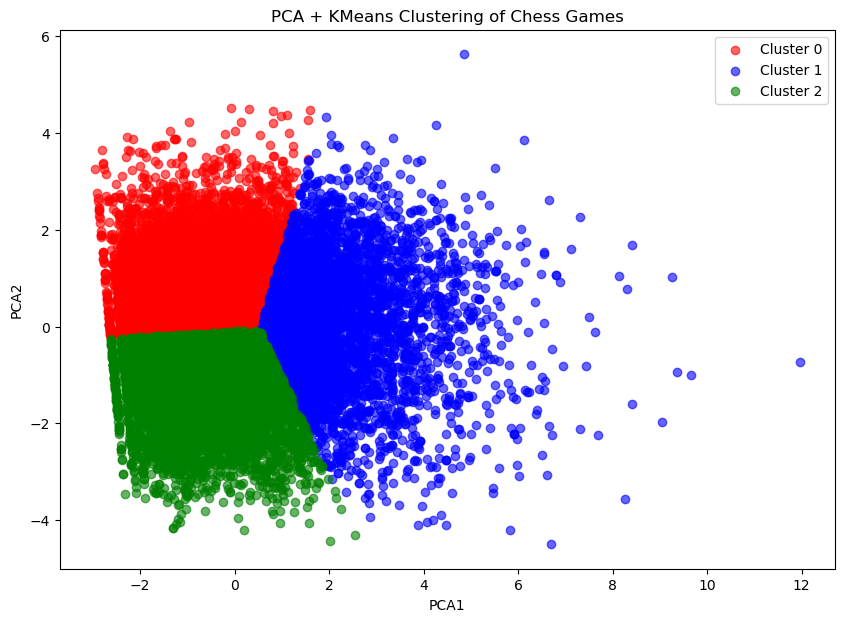

Explained Variance Ratio: [0.33325647 0.23172469]
cluster  result 
0        1-0        3394
         0-1        3226
         1/2-1/2     239
1        1-0        2118
         0-1        1914
         1/2-1/2     151
2        1-0        2853
         0-1        2693
         1/2-1/2     198
Name: result, dtype: int64


In [18]:
# Applying KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(pca_result)

plt.figure(figsize=(10, 7))
colors = ['red', 'blue', 'green']
for cluster in range(3):
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                label=f'Cluster {cluster}', alpha=0.6, color=colors[cluster])
plt.title('PCA + KMeans Clustering of Chess Games')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(pca_df.groupby('cluster')['result'].value_counts())


In [20]:
# Just some stats
cluster_stats = df.groupby('cluster')[features].describe()
print(cluster_stats)


        white_inaccuracies                                                \
                     count      mean       std  min  25%  50%  75%   max   
cluster                                                                    
0.0                 6859.0  2.754337  2.159608  0.0  1.0  2.0  4.0  16.0   
1.0                 4183.0  2.740617  2.102785  0.0  1.0  2.0  4.0  14.0   
2.0                 5744.0  2.685237  2.090454  0.0  1.0  2.0  4.0  13.0   

        white_mistakes            ... white_elo         black_elo  \
                 count      mean  ...       75%     max     count   
cluster                           ...                               
0.0             6859.0  1.167371  ...    1957.0  2994.0    6859.0   
1.0             4183.0  1.151805  ...    1934.0  3068.0    4183.0   
2.0             5744.0  1.149896  ...    1888.0  3181.0    5744.0   

                                                                          
                mean         std    min      25%     

Correlation matrix for Cluster 1.0:


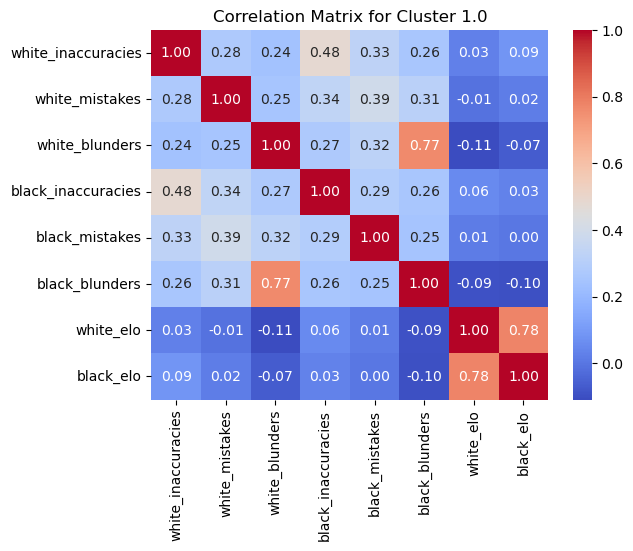

Correlation matrix for Cluster 2.0:


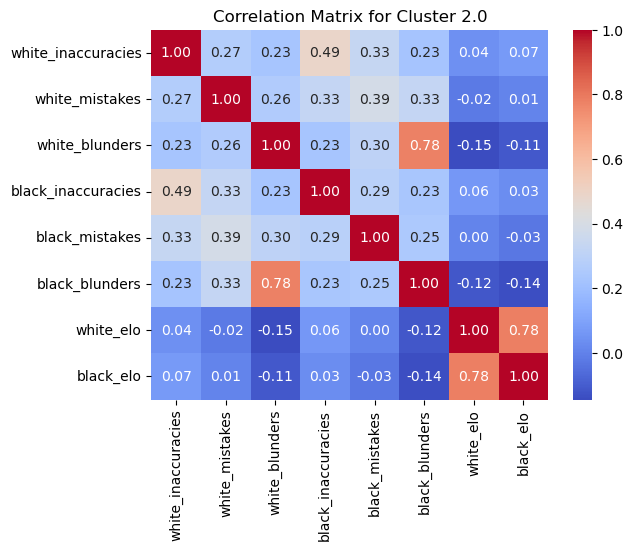

Correlation matrix for Cluster 0.0:


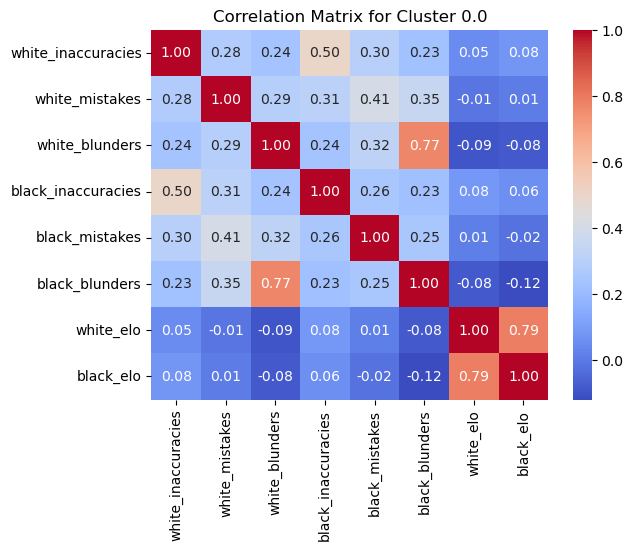

Correlation matrix for Cluster nan:


C:\Users\ripst\anaconda3\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\ripst\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


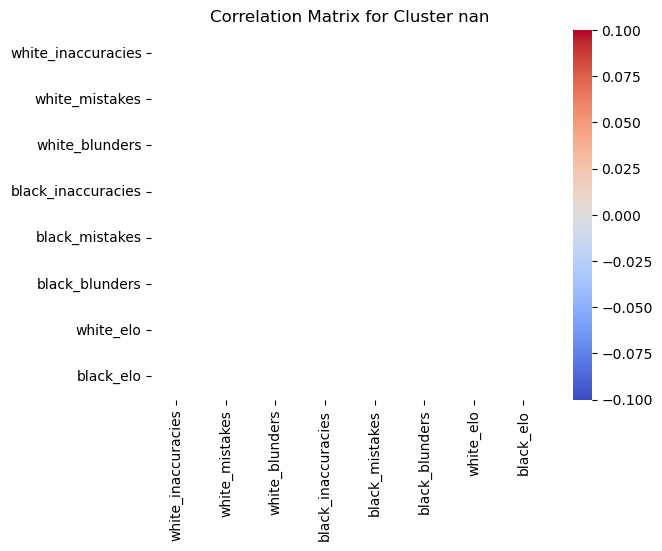

In [22]:
import seaborn as sns

# Take a look at the correlation matrix
for cluster in df['cluster'].unique():
    print(f"Correlation matrix for Cluster {cluster}:")
    cluster_data = df[df['cluster'] == cluster][features]
    corr_matrix = cluster_data.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()